### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
#from PIL import Image
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import time

In [46]:
# To make some of the conda packages work (Tensorboard and pydot)
PATH = os.getenv('PATH')
%env PATH=/home/henrik/anaconda3/envs/TF2/bin:$PATH

env: PATH=/home/henrik/anaconda3/envs/TF2/bin:/home/henrik/anaconda3/envs/TF2/bin:/home/henrik/anaconda3/bin:/home/henrik/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


Some parameters

In [2]:
EPOCHS = 50
BATCH_SIZE = 128
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3

In [ ]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/')

DATASET_SIZE = len(list(data_dir.glob('*/*/*.png')))
STEPS_PER_EPOCH = np.ceil(DATASET_SIZE/BATCH_SIZE)

class_names = np.array([item.name for item in data_dir.glob('train/*') if item.name != 'metadata.json'])
NUM_CLASSES = len(class_names)
print ("Class names: ",class_names)

# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

Class names:  ['cat' 'airplane' 'deer' 'automobile' 'ship' 'horse' 'truck' 'dog' 'bird'
 'frog']


In [49]:
samples_per_class = []

for class_name in class_names:
    class_samples = len(list(data_dir.glob('*/'+class_name+'/*.png')))
    samples_per_class.append(class_samples)
    print('{0:18}: {1:3d}'.format(class_name, class_samples))

print ('\nTotal number of images: {}, in {} classes'.format(DATASET_SIZE, NUM_CLASSES))

# If one class contains more than half of the entire sample size
if np.max(samples_per_class) > DATASET_SIZE//2:
    print ("But the dataset is mainly shit")

cat               : 6000
airplane          : 6000
deer              : 6000
automobile        : 6000
ship              : 6000
horse             : 6000
truck             : 6000
dog               : 6000
bird              : 6000
frog              : 6000

Total number of images: 60000, in 10 classes


### Loading images with `tf.data.Dataset`.

In [50]:
# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*/*'))

A short pure-tensorflow function that converts a file path to an `image_data, label` pair:

In [51]:
def get_label_int(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # get class integer from class-list
    label_int64 = tf.reduce_min(tf.where(tf.equal(parts[-2], class_names)))
    # cast to tensor array with dtype=uint8
    label_uint8 = tf.dtypes.cast(label_int64, tf.uint8)
    return tf.reshape(label_uint8, [-1])

def get_label_bool(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == class_names

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label_int(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Using `Dataset.map` to create a dataset of `Image, label` pairs:

In [52]:
# Set 'num_parallel_calls' so multiple images are loaded and processed in parallel
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

### Prepare dataset for training
Want the data to be shuffled and batched. Here we use the `tf.data` api.

Split into training, test and validation dataset

In [53]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

train_ds = labeled_ds.take(train_size)
test_ds = labeled_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [54]:
def augment(img, label):
    # Augment the image using tf.image
    # Standardize
    img = tf.image.per_image_standardization(img)
    # Pad with 8 pixels
    img = tf.image.resize_with_crop_or_pad(img, IMG_HEIGHT + 8, IMG_WIDTH + 8)
    # Randomly crop the image back to original size
    img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS])
    # Randomly flip image
    img = tf.image.random_flip_left_right(img)
    return img, label

# Augment the training data
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

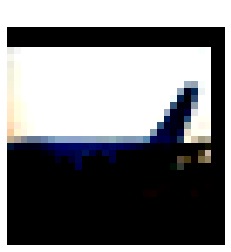

In [55]:
image, label = next(iter(train_ds))

plt.figure();
plt.figure(frameon=False, facecolor='white');
plt.title(class_names[label.numpy()][0], fontdict={'color':'white','size':20});
plt.imshow(image.numpy());
plt.axis('off');

In [56]:
def get_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

print ("{:32} {:>5}".format("Full dataset sample size:", get_size(labeled_ds)))
print ("{:32} {:>5}".format("Train dataset sample size:", get_size(train_ds)))
print ("{:32} {:>5}".format("Test dataset sample size:", get_size(test_ds)))
print ("{:32} {:>5}".format("Validation dataset sample size:", get_size(val_ds)))

Full dataset sample size:        60000
Train dataset sample size:       42000
Test dataset sample size:         9000
Validation dataset sample size:   9000


In [57]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [58]:
# Create training dataset
train_ds = prepare_for_training(train_ds, cache="./cache/cifar_train_ds.tfcache")
# Create test dataset
test_ds = prepare_for_training(test_ds, cache="./cache/cifar_test_ds.tfcache")
# Create validation dataset
val_ds = prepare_for_training(val_ds, cache="./cache/cifar_val_ds.tfcache")

## Training
See https://www.tensorflow.org/tutorials/images/cnn

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

Create the model

In [60]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          3

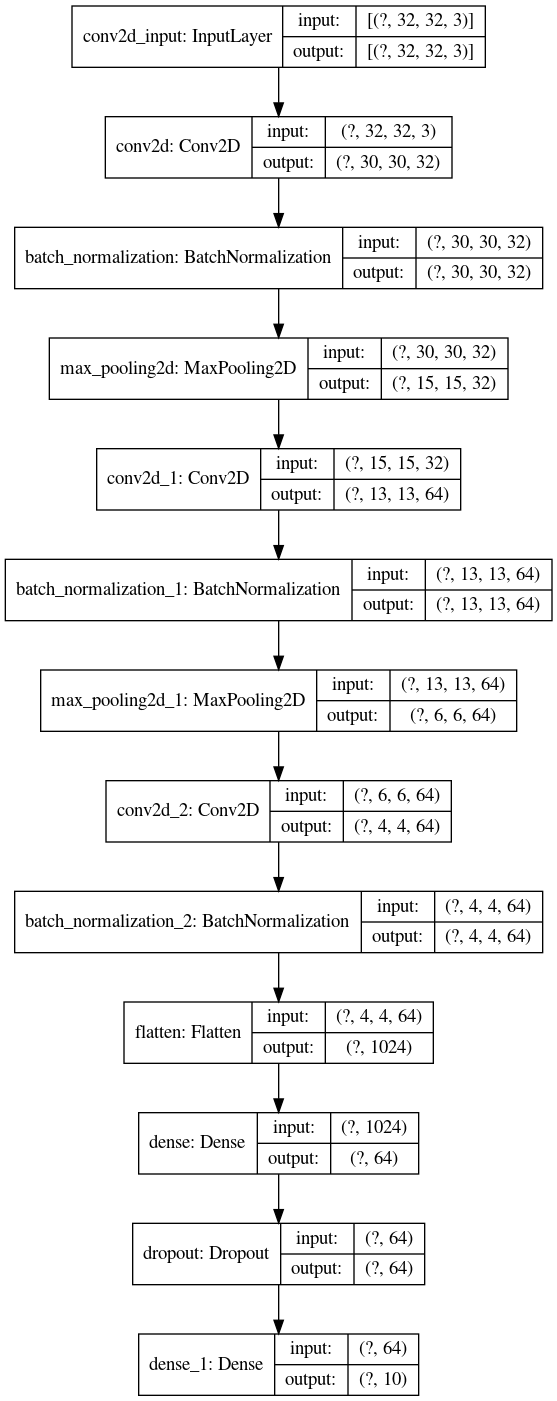

In [62]:
tf.keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

Compile and train the model

In [63]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [64]:
start = time.time()

history = model.fit(train_ds,
                    steps_per_epoch = train_size // BATCH_SIZE, # number of batches
                    epochs = EPOCHS, 
                    validation_data = test_ds,
                    validation_steps = test_size // BATCH_SIZE
                   )

end = time.time()
print("Time spent on training: {:0.2f}".format(end - start))

Train for 328 steps, validate for 70 steps
Epoch 1/50
328/328 [==============================] - 4s 11ms/step - loss: 1.5412 - accuracy: 0.4612 - val_loss: 2.3233 - val_accuracy: 0.2625
Epoch 2/50
328/328 [==============================] - 2s 6ms/step - loss: 1.0985 - accuracy: 0.6134 - val_loss: 1.1794 - val_accuracy: 0.5876
Epoch 3/50
328/328 [==============================] - 2s 6ms/step - loss: 0.9198 - accuracy: 0.6771 - val_loss: 0.9153 - val_accuracy: 0.6800
Epoch 4/50
328/328 [==============================] - 2s 6ms/step - loss: 0.8100 - accuracy: 0.7169 - val_loss: 0.9165 - val_accuracy: 0.6804
Epoch 5/50
328/328 [==============================] - 2s 6ms/step - loss: 0.7121 - accuracy: 0.7487 - val_loss: 0.7157 - val_accuracy: 0.7504
Epoch 6/50
328/328 [==============================] - 2s 6ms/step - loss: 0.6368 - accuracy: 0.7728 - val_loss: 0.8711 - val_accuracy: 0.7013
Epoch 7/50
328/328 [==============================] - 2s 6ms/step - loss: 0.5623 - accuracy: 0.7998 - va

## Evaluate the model

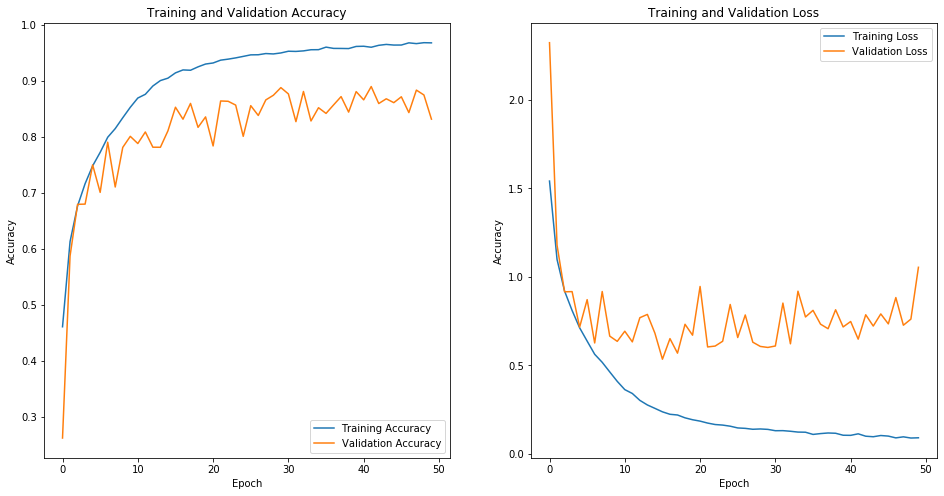

70/70 - 0s - loss: 1.0710 - accuracy: 0.8302


In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

test_loss, test_acc = model.evaluate(test_ds, verbose=2, steps=test_size//BATCH_SIZE)